In [1]:
import pandas as pd
import umap
import glob
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.cm as cm

from sklearn.neighbors import NearestNeighbors

from matplotlib import cm

from scipy.ndimage import uniform_filter1d
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

/home/jc225751/Runs/70_self-supervised_two-regions/Program/venv_natif/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metric = 'manhattan'

In [3]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
lab = "Sex"
model_path = glob.glob(f"{path}/*")[0]
ukb_emb_file = f"{model_path}/ukb40_random_embeddings/full_embeddings.csv"
print(ukb_emb_file)

/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_left/11-42-04_96_0/ukb40_random_embeddings/full_embeddings.csv


In [4]:
ukb_emb = pd.read_csv(ukb_emb_file, index_col=0)
ukb_emb.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-6.886244,-16.820978,8.099331,-10.514671,-30.140837,24.244686,-8.466900,28.940052,-54.686165,21.345762,...,1.981015,-29.928665,-3.997314,-9.788386,30.164188,22.871360,41.694633,41.231903,27.971186,-6.097128
sub-1000325,8.947813,-28.376537,15.904366,2.455116,11.030722,-34.153410,-24.070572,-7.631344,9.646596,23.222225,...,24.123500,22.399744,-16.600910,47.662567,-10.763619,-3.705989,97.605484,3.433647,-1.265362,16.143702
sub-1000458,20.397180,36.055670,18.354885,-15.088289,30.981411,28.449870,-11.366716,-17.852003,-3.051387,-6.577911,...,-70.063610,34.295593,6.632323,-32.835100,81.642380,5.919020,-40.601677,-30.885162,-2.944712,23.524616
sub-1000575,10.695792,17.692785,17.510502,4.335569,18.558039,-3.220756,-4.455990,18.646290,-18.129580,23.118652,...,-17.103268,15.174048,-19.464940,17.149805,-1.761782,6.378880,55.776047,32.165062,-14.498923,-1.355911
sub-1000606,-23.184350,-47.957153,12.845607,-45.286770,-15.052197,-15.585397,-30.070950,-20.966606,-16.975832,21.159243,...,13.791149,-41.245730,3.394850,22.052076,20.373089,-21.124270,63.938320,-40.523060,56.032192,3.844928


In [5]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[lab]].dropna()
participants.head()

,Sex
participant_id,
sub-3411469,1
sub-2290292,0
sub-3842391,0
sub-2758537,1
sub-4334619,1


In [6]:
merged = participants[[lab]].merge(ukb_emb, left_index=True, right_index=True)
# UKB latent space analysis

In [7]:
embeddings = merged.iloc[:,1:]
label = merged.iloc[:,0:1]
label_random = label.copy()
label_random[:] = label_random.sample(frac=1).values
# print(embeddings.head())
print(label.head())
print(label_random.head())

             Sex
sub-3411469    1
sub-2290292    0
sub-3842391    0
sub-2758537    1
sub-4334619    1
             Sex
sub-3411469    0
sub-2290292    1
sub-3842391    0
sub-2758537    0
sub-4334619    0


In [8]:
# Construct nearest_neighbor matrix
nbrs = NearestNeighbors(n_neighbors=int(len(embeddings)/2), metric=metric, algorithm='brute').fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)
indices.shape

(37715, 18857)

In [9]:
def construct_average_nearest_neighbors(label):
    # Takes list of incides whose label is 1
    label_red = label.reset_index()[[lab]]
    label_1 = label_red[label_red[lab]==1].index.to_list()
    
    # In the indices matrix, put value of label corresponding to index
    neighbors = indices[:,1:]
    labels1 = np.in1d(neighbors, label_1)
    labels1 = labels1.reshape(neighbors.shape).astype(int)
    
    # Makes moving average along nearest neighbor
    labels1_cum = np.cumsum(labels1, axis=1)
    means_npy = np.zeros(labels1_cum.shape)
    for idx in range(len(labels1)):
        means_npy[idx,:] = labels1_cum[idx,:]/(np.arange(1, labels1_cum.shape[1]+1, 1).reshape(1,-1))
        
    return labels1, means_npy

In [10]:
def construct_average_distance_nearest_neighbors():

    # Makes moving average along nearest neighbor
    distances_cum = np.cumsum(distances[:,1:], axis=1)
    means_distance = np.zeros(distances_cum.shape)
    for idx in range(len(distances)):
        means_distance[idx,:] = distances_cum[idx,:]/(np.arange(1, distances_cum.shape[1]+1, 1).reshape(1,-1))
        
    return means_distance

In [11]:
values_npy, means_npy = construct_average_nearest_neighbors(label)

In [12]:
means_distance = construct_average_distance_nearest_neighbors()

In [13]:
val_random_npy, random_npy = construct_average_nearest_neighbors(label_random)

In [14]:
def create_mean_interval(values_npy):
    i=0
    limits = [0]
    while (i<values_npy.shape[1]):
        j = min(2*i+1, values_npy.shape[1])
        limits.append(j)
        i = j
    limits = limits[:-1]
    print(limits)
    means_interval = np.zeros((values_npy.shape[0], (len(limits)-1)))
    for i in range(len(limits)-1):
        means_interval[:,i] = np.mean(values_npy[:, :limits[i+1]], axis=1)
    return means_interval, limits

In [15]:
means_interval, limits = create_mean_interval(values_npy)

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [16]:
means_distance_interval, _ = create_mean_interval(distances[:,1:])

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [17]:
means_distance_interval.shape

(37715, 14)

In [18]:
means_random_interval, _ = create_mean_interval(val_random_npy)

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095, 8191, 16383]


In [19]:
print(len(limits), means_interval.shape[1])

15 14


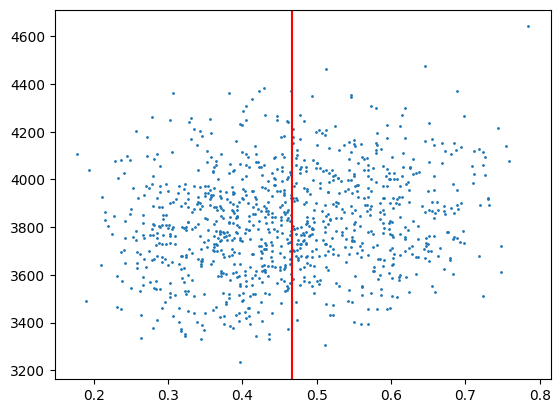

In [20]:
nb_interval=8
number=1000
plt.scatter(means_interval[:number, nb_interval], means_distance_interval[:number, nb_interval], s=1)
plt.axvline(x=np.mean(label.values), color='r', linestyle='-')
# plt.axhline(y=0, color='black', linestyle='-')
# plt.axhline(y=1, color='black', linestyle='-')

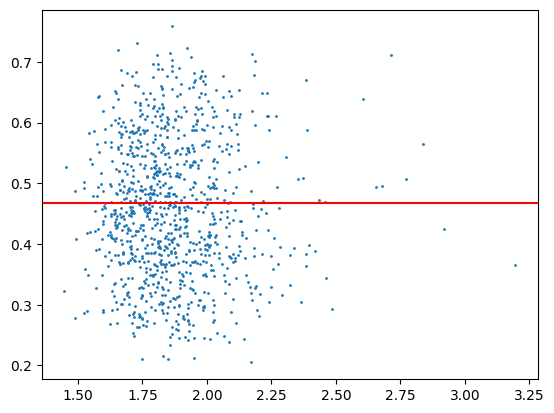

In [21]:
nb_interval=1000
number=1000
plt.scatter(means_distance[:number, nb_interval]/means_distance[:number, 1], means_npy[:number, nb_interval], s=1)
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')

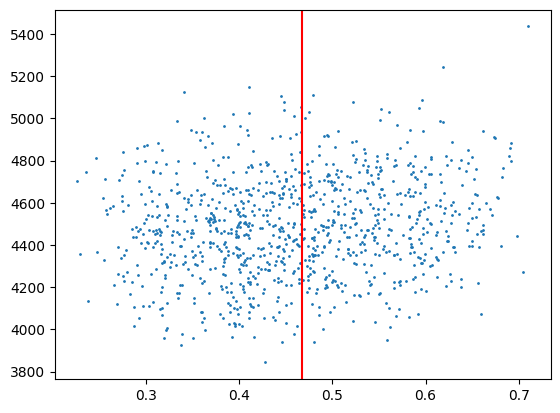

In [22]:
nb_interval=10
number=1000
plt.scatter(means_interval[:number, nb_interval], means_distance_interval[:number, nb_interval], s=1)
plt.axvline(x=np.mean(label.values), color='r', linestyle='-')
# plt.axhline(y=0, color='black', linestyle='-')
# plt.axhline(y=1, color='black', linestyle='-')

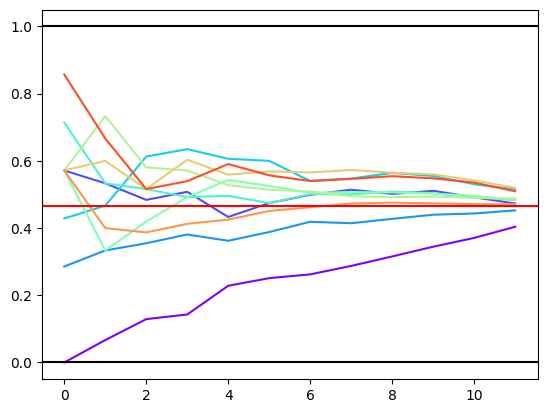

In [23]:
number=10
for idx in range(number):
    idx2 = (idx+1000)
    plt.plot(means_interval[idx2, 2:], c = cm.rainbow(1.*idx/number))
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')

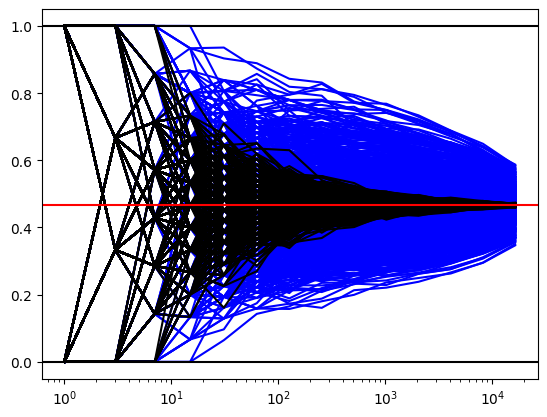

In [24]:
for idx in range(1,35000,50):
    plt.plot(limits[1:], means_interval[idx, :], color='b')
for idx in range(1,35000,50):
    plt.plot(limits[1:], means_random_interval[idx, :], color='black')
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.xscale('log')

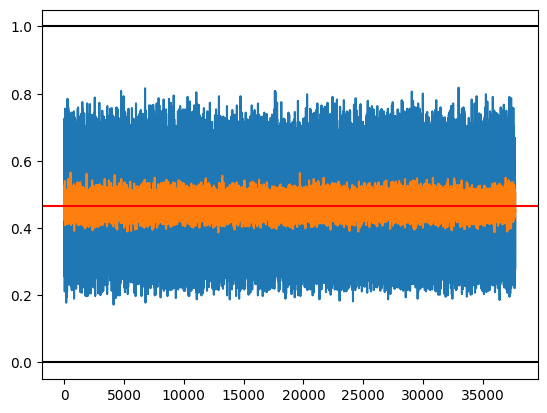

In [25]:
nb_interval=8
plt.plot(means_interval[:, nb_interval])
plt.plot(means_random_interval[:, nb_interval])
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

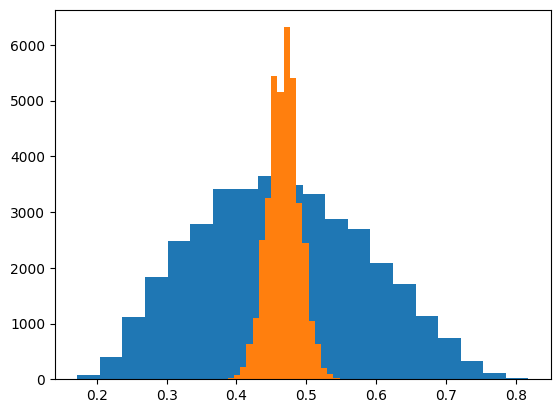

In [26]:
nb_interval=8
plt.hist(means_interval[:, nb_interval], bins=20)
plt.hist(means_random_interval[:, nb_interval], bins=20)
plt.show()

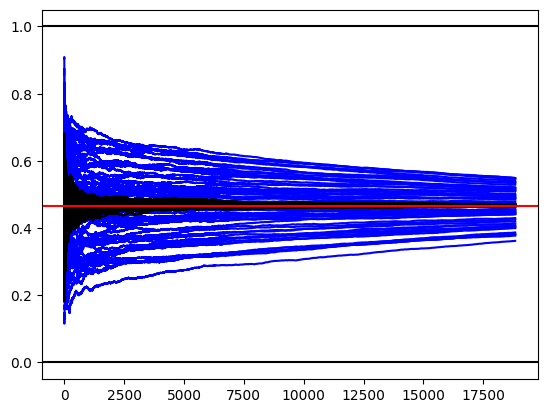

In [27]:
for idx in range(1,35000,500):
    plt.plot(means_npy[idx, 20:], color='b')
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, 20:], color='black')
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

In [28]:
nb_neighbors=1000
print(np.min(means_npy[:, nb_neighbors]))
print(np.argmin(means_npy[:, nb_neighbors]))
label.iloc[np.argmin(means_npy[:, nb_neighbors]),:]

0.1938061938061938
21346


Sex    0
Name: sub-2354190, dtype: int64

In [29]:
nb_neighbors=1000
print(np.max(means_npy[:, nb_neighbors]))
print(np.argmax(means_npy[:, nb_neighbors]))
label.iloc[np.argmax(means_npy[:, nb_neighbors]),:]

0.7992007992007992
32981


Sex    0
Name: sub-3615019, dtype: int64

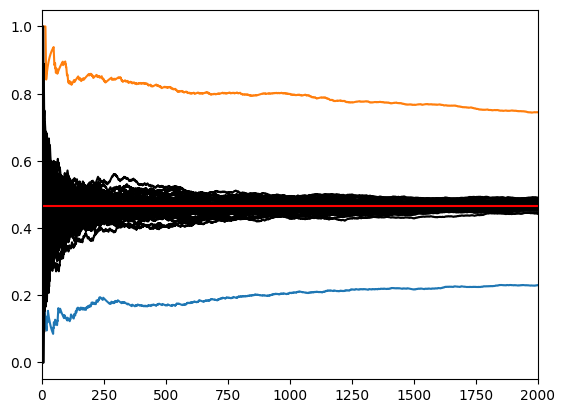

: 

In [45]:
nb_neighbors=500
plt.plot(means_npy[np.argmin(means_npy[:, nb_neighbors]), :])
plt.plot(means_npy[np.argmax(means_npy[:, nb_neighbors]), :])
for idx in range(1,35000,500):
    plt.plot(random_npy[idx, :], color='black')
    plt.xlim((0,2000))
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')

(37715, 18856)
(18856,)


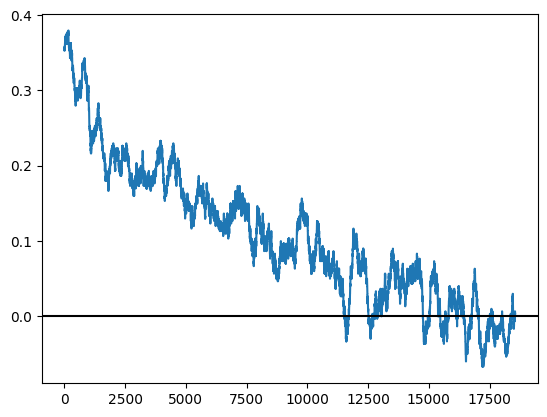

In [31]:
nb_neighbors=1000
N=300
idx=np.argmax(means_npy[:, nb_neighbors])
val_idx=np.max(means_npy[:, nb_neighbors])
avg = np.mean(label.values)
# avg=means_npy[idx, 17000]
arr_to_derivate = values_npy[idx, :]-avg
arr_to_plot = uniform_filter1d(arr_to_derivate, N, mode='constant', cval=(val_idx-avg))
# plt.plot(np.convolve(values_npy[np.argmax(means_npy[:, nb_neighbors]), :]-np.mean(label.values), np.ones(N)/N)[N:-N])
plt.plot(arr_to_plot[:-N])
plt.axhline(y=0, color='black', linestyle='-')
print(means_npy.shape)
print(arr_to_plot.shape)

(37715, 18856)
(18856,)


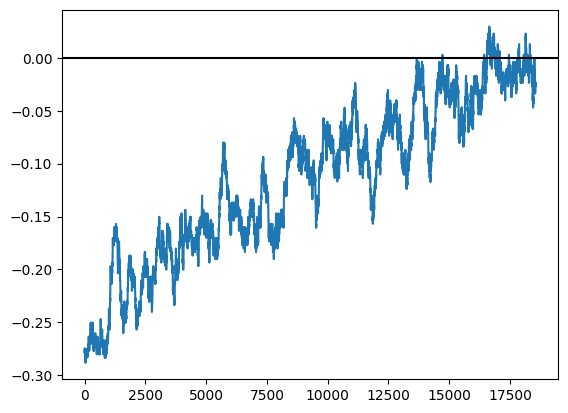

In [32]:
nb_neighbors=1000
N=300
idx=np.argmin(means_npy[:, nb_neighbors])
val_idx=np.min(means_npy[:, nb_neighbors])
avg = np.mean(label.values)
# avg=means_npy[idx, 17000]
arr_to_derivate = values_npy[idx, :]-avg
arr_to_plot = uniform_filter1d(arr_to_derivate, N, mode='constant', cval=(val_idx-avg))
# plt.plot(np.convolve(values_npy[np.argmax(means_npy[:, nb_neighbors]), :]-np.mean(label.values), np.ones(N)/N)[N:-N])
plt.plot(arr_to_plot[:-N])
plt.axhline(y=0, color='black', linestyle='-')
print(means_npy.shape)
print(arr_to_plot.shape)

In [33]:
print(means_npy.shape)
print(arr_to_plot.shape)
print(indices.shape)
print(distances.shape)
print(np.max(indices))

(37715, 18856)
(18856,)
(37715, 18857)
(37715, 18857)
37714


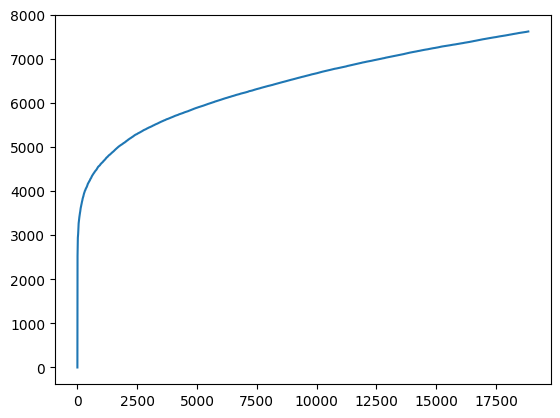

In [34]:
nb_neighbors=1000
idx=np.argmin(means_npy[:, nb_neighbors])
plt.plot(distances[idx, :])

<Axes: >

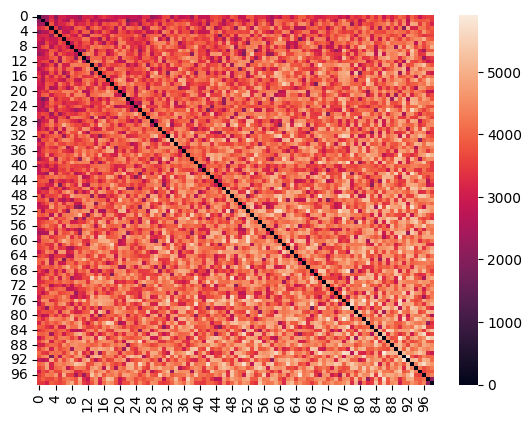

In [36]:
nb_neighbors=1000
idx=np.argmin(means_npy[:, nb_neighbors])
dist = pdist(embeddings.values[indices[idx, 1:100],:], metric='cityblock')
sns.heatmap(squareform(dist))

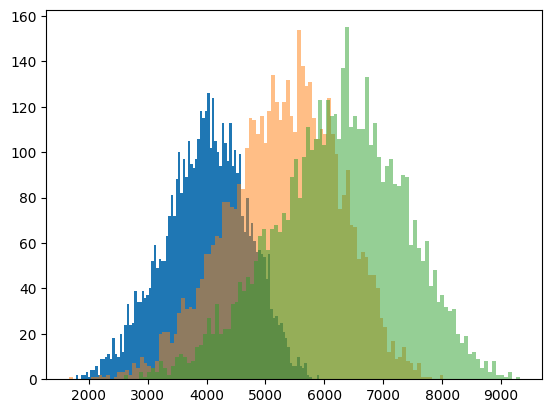

In [37]:
dist1 = pdist(embeddings.values[indices[idx, 1:100],:], metric='cityblock')
dist2 = pdist(embeddings.values[indices[idx, 1000:1100],:], metric='cityblock')
dist3 = pdist(embeddings.values[indices[idx, 5000:5100],:], metric='cityblock')
h = plt.hist(dist1, bins=100)
h = plt.hist(dist2, bins=100, alpha=0.5)
h = plt.hist(dist3, bins=100, alpha=0.5)

In [38]:
np.where(values_npy[idx]==0)

(array([    0,     1,     3, ..., 18853, 18854, 18855]),)

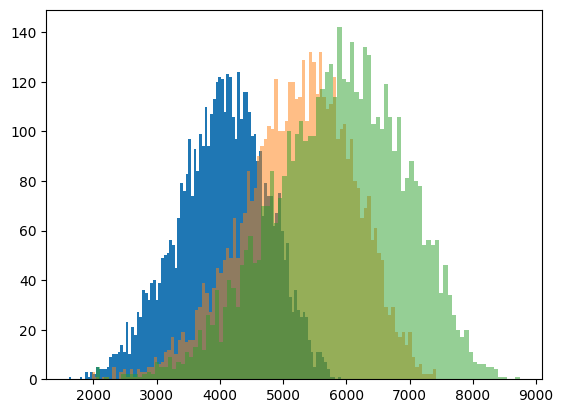

In [39]:
indices_0 = np.where(values_npy[idx]==0)[0]
dist1 = pdist(embeddings.values[indices[idx, indices_0[1:100]],:],  metric='cityblock')
dist2 = pdist(embeddings.values[indices[idx, indices_0[500:600]],:],  metric='cityblock')
dist3 = pdist(embeddings.values[indices[idx, indices_0[2000:2100]],:],  metric='cityblock')
h = plt.hist(dist1, bins=100)
h = plt.hist(dist2, bins=100, alpha=0.5)
h = plt.hist(dist3, bins=100, alpha=0.5)

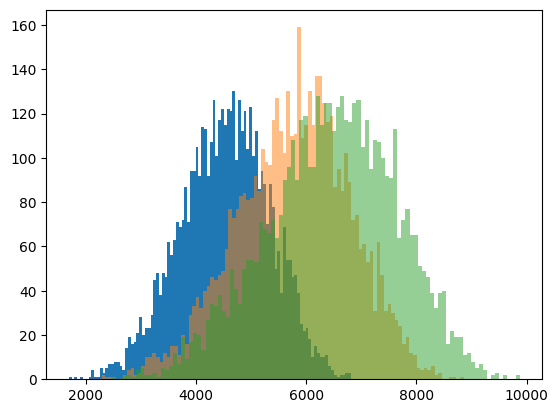

In [40]:
indices_0 = np.where(values_npy[0]==0)[0]
dist1 = pdist(embeddings.values[indices[0, indices_0[1:100]],:],  metric='cityblock')
dist2 = pdist(embeddings.values[indices[0, indices_0[500:600]],:],  metric='cityblock')
dist3 = pdist(embeddings.values[indices[0, indices_0[2000:2100]],:],  metric='cityblock')
h = plt.hist(dist1, bins=100)
h = plt.hist(dist2, bins=100, alpha=0.5)
h = plt.hist(dist3, bins=100, alpha=0.5)

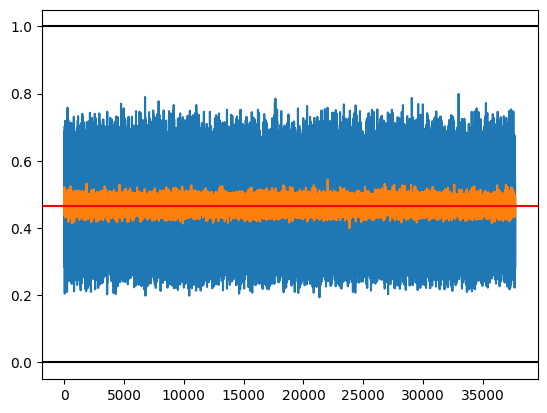

In [41]:
plt.plot(means_npy[:, 1000])
plt.plot(random_npy[:, 1000])
plt.axhline(y=np.mean(label.values), color='r', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()